In [6]:
from google.colab import drive
drive.mount('/content/drive')
import os
import nibabel as nib
import numpy as np

!pip install nibabel

Mounted at /content/drive


It's helpful to first build an intuition on the dataset. We already know the pku data are of size (512,512,N), and there may be missing organ indices on some slices. Let's see the size and labels of the "other" data.

In [ ]:
# import os
# import nibabel as nib
# import numpy as np

# # folder_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Mask/'
# folder_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/label/'

# unique_integers_list = []
# file_sizes_list = []

# # Check if path exists first
# if os.path.exists(folder_path):
#     # Get all .nii.gz files sorted to ensure consistent order
#     nii_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.nii.gz')])

#     print(f"Found {len(nii_files)} files. Processing...")

#     for f in nii_files:
#         file_path = os.path.join(folder_path, f)
#         try:
#             img = nib.load(file_path)
#             # get_fdata() loads data as float, casting to int since you mentioned pixels are integers
#             data = img.get_fdata().astype(int)

#             # Get unique values
#             unique_vals = np.unique(data).tolist()
#             unique_integers_list.append(unique_vals)

#             # Get shape (Length, Width, Height)
#             file_sizes_list.append(list(img.shape))
#         except Exception as e:
#             print(f"Error processing {f}: {e}")

#     print("Unique integers list:")
#     print(unique_integers_list)
#     print("\nFile sizes list:")
#     print(file_sizes_list)
# else:
#     print(f"Directory not found: {folder_path}")

It seems that the pku data and other sources of data are both of size (512,512,x). But not all indices are appearing on a certain slice.

Next, let's see what's contained in the header (matadata) of the dataset.

In [ ]:
# folder_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Image/'
# file_name = 'Case_00002_0000.nii.gz'
# file_path = os.path.join(folder_path, file_name)

# if os.path.exists(file_path):
#     try:
#         img = nib.load(file_path)
#         print(f"Metadata for {file_name}:")
#         # The header contains various metadata about the NIfTI file
#         print(img.header)
#     except Exception as e:
#         print(f"Error loading or processing {file_name}: {e}")
# else:
#     print(f"File not found: {file_path}")

Among these various matadata, qoffset is just a translation, setting the position of the origin (i=0,j=0,k=0) in real space.

One thing to notice is the physical size for each pixel of these .nii.gz CT image, which is stored in pixdim[1:4]. For example, some may have $\Delta z=4mm$ but the others may have $\Delta z=1mm$. This means that one pixel corresponds to different real-space physical volume. However, it seems that we don't need to care about $\Delta z$, since we only consider 2D images. Different $\Delta x,\Delta y$ also don't matter, since it in fact acts as scaling, saving the step of performing this data augmentation process.

Below shows the histogram of physical pixel sizes among the 'other' dataset and pku dataset.

In [ ]:
# import matplotlib.pyplot as plt
# # for other dataset
# folder_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Image/'

# x_spacings = []
# y_spacings = []
# z_spacings = []

# if os.path.exists(folder_path):
#     nii_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.nii.gz')])
#     print(f"Found {len(nii_files)} files. collecting metadata...")

#     for f in nii_files:
#         file_path = os.path.join(folder_path, f)
#         try:
#             img = nib.load(file_path)
#             header = img.header
#             # pixdim[1], [2], [3] correspond to spatial dimensions x, y, z
#             x_spacings.append(header['pixdim'][1])
#             y_spacings.append(header['pixdim'][2])
#             z_spacings.append(header['pixdim'][3])
#         except Exception as e:
#             print(f"Error reading {f}: {e}")

#     # Plotting
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     axes[0].hist(x_spacings, bins=20, color='skyblue', edgecolor='black')
#     axes[0].set_title('Histogram of Pixel Size (Dim 1) in other dataset')
#     axes[0].set_xlabel('Size (mm)')
#     axes[0].set_ylabel('Count')

#     axes[1].hist(y_spacings, bins=20, color='lightgreen', edgecolor='black')
#     axes[1].set_title('Histogram of Pixel Size (Dim 2) in other dataset')
#     axes[1].set_xlabel('Size (mm)')

#     axes[2].hist(z_spacings, bins=20, color='salmon', edgecolor='black')
#     axes[2].set_title('Histogram of Pixel Size (Dim 3) in other dataset')
#     axes[2].set_xlabel('Size (mm)')

#     plt.tight_layout()
#     plt.show()

# else:
#     print(f"Directory not found: {folder_path}")

# # For pku dataset
# folder_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/ct/'

# x_spacings = []
# y_spacings = []
# z_spacings = []

# if os.path.exists(folder_path):
#     nii_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.nii.gz')])
#     print(f"Found {len(nii_files)} files. collecting metadata...")

#     for f in nii_files:
#         file_path = os.path.join(folder_path, f)
#         try:
#             img = nib.load(file_path)
#             header = img.header
#             # pixdim[1], [2], [3] correspond to spatial dimensions x, y, z
#             x_spacings.append(header['pixdim'][1])
#             y_spacings.append(header['pixdim'][2])
#             z_spacings.append(header['pixdim'][3])
#         except Exception as e:
#             print(f"Error reading {f}: {e}")

#     # Plotting
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     axes[0].hist(x_spacings, bins=20, color='skyblue', edgecolor='black')
#     axes[0].set_title('Histogram of Pixel Size (Dim 1) in pku dataset')
#     axes[0].set_xlabel('Size (mm)')
#     axes[0].set_ylabel('Count')

#     axes[1].hist(y_spacings, bins=20, color='lightgreen', edgecolor='black')
#     axes[1].set_title('Histogram of Pixel Size (Dim 2) in pku dataset')
#     axes[1].set_xlabel('Size (mm)')

#     axes[2].hist(z_spacings, bins=20, color='salmon', edgecolor='black')
#     axes[2].set_title('Histogram of Pixel Size (Dim 3) in pku dataset')
#     axes[2].set_xlabel('Size (mm)')

#     plt.tight_layout()
#     plt.show()

# else:
#     print(f"Directory not found: {folder_path}")

Also, for 'other' dataset, not every CT .nii.gz image has corresponding label file. So I'll remove those without labels.

In [ ]:
Image_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Image/'
Mask_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Mask/'
mask_idx = set()

if os.path.exists(Mask_path):
  nii_files = sorted([f for f in os.listdir(Mask_path) if f.endswith('.nii.gz')])
  # f looks like Case_00001.nii.gz
  for f in nii_files:
    identifier = f.replace('Case_', '').replace('.nii.gz', '')
    mask_idx.add(identifier)

  print(f"Found {len(nii_files)} mask files. Extracting identifiers...")

else:
  print(f"Mask directory not found: {Mask_path}")


if os.path.exists(Image_path):
  nii_files = sorted([f for f in os.listdir(Image_path) if f.endswith('.nii.gz')])
  num = len(nii_files)
  for f in nii_files:
    identifier = f.replace('Case_', '').replace('_0000.nii.gz', '')

    if identifier not in mask_idx:
      print(f"Removing {f}...")
      os.remove(os.path.join(Image_path, f))
      num -= 1
    else:
      mask_idx.remove(identifier)
  print(f"{num} files remain in Image directory: {Image_path}")
  print(f"{len(mask_idx)} files in Mask have no corresponding images:\
  {mask_idx}")
else:
  print(f"Image directory not found: {Image_path}")

Found 41 mask files. Extracting identifiers...
41 files remain in Image directory: /content/drive/MyDrive/med_segmentation/other_train_dataset/Image/
0 files in Mask have no corresponding images:  set()


Let's then build some intuition on the CT image, especially the range of values.

In [ ]:
# # 1. Define the folder path
# folder_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/ct/'

# # 2. Specify the file name
# file_name = '1.nii.gz'

# # 3. Construct the full file path
# file_path = os.path.join(folder_path, file_name)

# # 4. Load the .nii.gz image file
# if os.path.exists(file_path):
#     img = nib.load(file_path)
#     print(f"Successfully loaded {file_name}.")
#     print(f"Image data shape: {img.shape}")
# else:
#     print(f"Error: File not found at {file_path}")

# data = img.get_fdata()
# print(f"Data type: {data.dtype}")
# print(f"Data shape: {data.shape}")
# print(f"Minimum pixel value: {data.min()}")
# print(f"Maximum pixel value: {data.max()}")

In [ ]:
# import matplotlib.pyplot as plt
# from ipywidgets import interact, IntSlider, fixed

# def plot_slice(slice_idx, data, global_min, global_max):
#     plt.figure(figsize=(10, 10))
#     plt.imshow(data[:, :, slice_idx], cmap='gray', vmin=global_min, vmax=global_max)
#     plt.title(f'Slice {slice_idx + 1}/{data.shape[2]}')
#     plt.axis('off')
#     cbar = plt.colorbar(shrink=0.7)
#     cbar.set_label('Pixel Value (HU)')
#     plt.show()

# # Get global min and max for consistent color scaling across all slices
# global_min_value = data.min()
# global_max_value = data.max()

# # Create an interactive slider for scrolling through slices
# interact(plot_slice,
#          slice_idx=IntSlider(min=0, max=data.shape[2]-1, step=1, value=data.shape[2]//2,
#                              description='Slice Index'),
#          data=fixed(data),
#          global_min=fixed(global_min_value),
#          global_max=fixed(global_max_value)
#         );

Next, I'll preprocess the .nii.gz files to generate numerous .npy files, each corresponding 2D data.

Notice: In 'other' dataset, the labels are defined as:

liver (label=1), kidney (label=2), spleen (label=3), and pancreas (label=4)

But in pku dataset, the labels are defined as:

1: Bladder, 2: Colon, 3: Femur Head L, 4: Femur Head R, 5: Kidney L, 6: Kidney R, 7: Liver, 8: Rectum, 9: SmallIntestine, 10: SpinalCord, 11: Stomach

To simultaneously take advantage of both datasets, in the following process I'll rearrange the label files defined as:

0: Background, 1: Bladder, 2: Colon, 3: Femur Head, 4: Kidney, 5: Liver, 6: Rectum, 7: SmallIntestine, 8: SpinalCord, 9: Stomach, 10: Spleen, 11: Pancreas

In [14]:
import os
import nibabel as nib
import numpy as np

# Define the base path for the output directory
output_base_path = '/content/processed_data/'

# Define subdirectories for images and masks
output_images_path = os.path.join(output_base_path, 'images_2d/')
output_masks_path = os.path.join(output_base_path, 'masks_2d/')

# Create the directories if they do not already exist
os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_masks_path, exist_ok=True)

# Define the base input paths for the NIfTI image and mask files
image_input_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/ct/'
mask_input_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/label/'

# Rearrange the index
pku_label_rearrange = {0:0, 1:1, 2:2, 3:3, 4:3, 5:4, 6:4, 7:5, 8:6, 9:7, 10:8, 11:9}

# Get sorted lists of all .nii.gz files from both directories
image_files_raw = sorted([f for f in os.listdir(image_input_path) if f.endswith('.nii.gz')])
mask_files_raw = sorted([f for f in os.listdir(mask_input_path) if f.endswith('.nii.gz')])

# Create dictionaries for easy lookup
image_dict = {f.replace('.nii.gz', ''): f for f in image_files_raw}
mask_dict = {f.replace('.nii.gz', ''): f for f in mask_files_raw}

# Pair each image file with its corresponding mask file
paired_files = []
for base_name in sorted(image_dict.keys()):
    if base_name in mask_dict:
        image_full_path = os.path.join(image_input_path, image_dict[base_name])
        mask_full_path = os.path.join(mask_input_path, mask_dict[base_name])
        paired_files.append((image_full_path, mask_full_path))


# Clipping values for Hounsfield Units
min_clip_value = -800
max_clip_value = 300

print(f"Starting processing of {len(paired_files)} image-mask pairs...")

processed_count = 0

for image_full_path, mask_full_path in paired_files:
    # Extract base name for consistent file naming, e.g., '1' from '1.nii.gz'
    base_name = os.path.basename(image_full_path).replace('.nii.gz', '')

    try:
        # Load 3D image and mask data into memory
        image_nifti = nib.load(image_full_path)
        mask_nifti = nib.load(mask_full_path)

        image_data = image_nifti.get_fdata()
        # Ensure mask data is integer type for labels, using np.int8 for memory efficiency
        original_mask_data = mask_nifti.get_fdata().astype(np.int8)
        max_key = max(pku_label_rearrange.keys())
        lut = np.array([pku_label_rearrange[k] for k in range(max_key+1)])
        mask_data = lut[original_mask_data]

        # Basic shape consistency check
        if image_data.shape != mask_data.shape:
            print(f"Warning: Shape mismatch for {base_name}. Skipping. Image: {image_data.shape}, Mask: {mask_data.shape}")
            # Explicitly clear 3D data from memory for the current pair
            del image_nifti, mask_nifti, image_data, mask_data
            continue # Move to the next pair

        num_slices = image_data.shape[2] # Number of slices along the depth (z) dimension

        for z in range(num_slices):
            # Extract 2D slices for current depth (z)
            original_image_slice = image_data[:, :, z]
            original_mask_slice = mask_data[:, :, z]

            # --- Image Preprocessing: Clip and Rescale ---
            # 1. Clip pixel values to the defined Hounsfield Unit range
            clipped_image_slice = np.clip(original_image_slice, min_clip_value, max_clip_value)
            # 2. Rescale clipped values to [0, 1] range
            preprocessed_image_slice = (clipped_image_slice - min_clip_value) / (max_clip_value - min_clip_value)

            # List to hold all variations (original + augmented) for the current z-slice
            slices_to_save = []
            # Add original (preprocessed) slices with rotation angle 0
            slices_to_save.append((preprocessed_image_slice, original_mask_slice, 0))

            # --- Data Augmentation: Rotations ---
            # Apply 90, 180, and 270-degree rotations using np.rot90
            for k, angle in enumerate([90, 180, 270]):
                # k=0 for 90 deg, k=1 for 180 deg, k=2 for 270 deg
                rotated_image_slice = np.rot90(preprocessed_image_slice, k=k+1)
                rotated_mask_slice = np.rot90(original_mask_slice, k=k+1)
                slices_to_save.append((rotated_image_slice, rotated_mask_slice, angle))

            # --- Save all generated slices ---
            for img_slice, msk_slice, angle in slices_to_save:
                # Construct filenames including original base name, slice index, and rotation angle
                image_filename = f"{base_name}_slice_{z:03d}_rot_{angle}.npy"
                mask_filename = f"{base_name}_slice_{z:03d}_rot_{angle}.npy"

                # Save image slices as float32 to preserve intensity information
                np.save(os.path.join(output_images_path, image_filename), img_slice.astype(np.float32))
                # Save mask slices as int8 to keep them as labels and be memory efficient
                np.save(os.path.join(output_masks_path, mask_filename), msk_slice.astype(np.int8))

        processed_count += 1
        print(f"Processed {processed_count}/{len(paired_files)}: {base_name} ({num_slices} slices, 4 variations each)")

        # Explicitly clear 3D data from memory for the current pair to avoid memory overflow
        del image_nifti, mask_nifti, image_data, mask_data

    except Exception as e:
        print(f"Error processing {base_name}: {e}")
        # Attempt to clear memory even on error to prevent issues for subsequent files
        if 'image_nifti' in locals(): del image_nifti
        if 'mask_nifti' in locals(): del mask_nifti
        if 'image_data' in locals(): del image_data
        if 'mask_data' in locals(): del mask_data
        continue # Continue to the next file pair even if one fails

print("\nFinished processing all NIfTI files.")

Starting processing of 72 image-mask pairs...
Processed 1/72: 1 (76 slices, 4 variations each)
Processed 2/72: 100 (93 slices, 4 variations each)
Processed 3/72: 102 (107 slices, 4 variations each)
Processed 4/72: 103 (111 slices, 4 variations each)
Processed 5/72: 105 (92 slices, 4 variations each)
Processed 6/72: 106 (107 slices, 4 variations each)
Processed 7/72: 107 (98 slices, 4 variations each)
Processed 8/72: 11 (74 slices, 4 variations each)
Processed 9/72: 12 (89 slices, 4 variations each)
Processed 10/72: 13 (81 slices, 4 variations each)
Processed 11/72: 14 (87 slices, 4 variations each)
Processed 12/72: 16 (80 slices, 4 variations each)
Processed 13/72: 17 (83 slices, 4 variations each)
Processed 14/72: 2 (89 slices, 4 variations each)
Processed 15/72: 20 (76 slices, 4 variations each)
Processed 16/72: 21 (72 slices, 4 variations each)
Processed 17/72: 22 (69 slices, 4 variations each)
Processed 18/72: 23 (69 slices, 4 variations each)
Processed 19/72: 25 (83 slices, 4 vari

In [15]:
# Then, preprocess all the 'other' .nii.gz CT images & masks.
# Define the base input paths for the NIfTI image and mask files
image_input_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Image/'
mask_input_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Mask/'

# Rearrange the index
other_label_rearrange = {0:0, 1:7, 2:6, 3:10, 4:11}

# Get sorted lists of all .nii.gz files from both directories
image_files_raw = sorted([f for f in os.listdir(image_input_path) if f.endswith('.nii.gz')])
mask_files_raw = sorted([f for f in os.listdir(mask_input_path) if f.endswith('.nii.gz')])

# Create dictionaries for easy lookup
image_dict = {f.replace('_0000.nii.gz', ''): f for f in image_files_raw}
mask_dict = {f.replace('.nii.gz', ''): f for f in mask_files_raw}

# Pair each image file with its corresponding mask file
paired_files = []
for base_name in sorted(image_dict.keys()):
    if base_name in mask_dict:
        image_full_path = os.path.join(image_input_path, image_dict[base_name])
        mask_full_path = os.path.join(mask_input_path, mask_dict[base_name])
        paired_files.append((image_full_path, mask_full_path))


# Clipping values for Hounsfield Units
min_clip_value = -800
max_clip_value = 300

print(f"Starting processing of {len(paired_files)} image-mask pairs...")

processed_count = 0

for image_full_path, mask_full_path in paired_files:
    # Extract base name for consistent file naming, e.g., '1' from '1.nii.gz'
    base_name = os.path.basename(image_full_path).replace('.nii.gz', '')

    try:
        # Load 3D image and mask data into memory
        image_nifti = nib.load(image_full_path)
        mask_nifti = nib.load(mask_full_path)

        image_data = image_nifti.get_fdata()
        # Ensure mask data is integer type for labels, using np.int8 for memory efficiency
        original_mask_data = mask_nifti.get_fdata().astype(np.int8)
        max_key = max(other_label_rearrange.keys())
        lut = np.array([other_label_rearrange[k] for k in range(max_key+1)])
        mask_data = lut[original_mask_data]

        # Basic shape consistency check
        if image_data.shape != mask_data.shape:
            print(f"Warning: Shape mismatch for {base_name}. Skipping. Image: {image_data.shape}, Mask: {mask_data.shape}")
            # Explicitly clear 3D data from memory for the current pair
            del image_nifti, mask_nifti, image_data, mask_data
            continue # Move to the next pair

        num_slices = image_data.shape[2] # Number of slices along the depth (z) dimension

        for z in range(num_slices):
            # Extract 2D slices for current depth (z)
            original_image_slice = image_data[:, :, z]
            original_mask_slice = mask_data[:, :, z]

            # --- Image Preprocessing: Clip and Rescale ---
            # 1. Clip pixel values to the defined Hounsfield Unit range
            clipped_image_slice = np.clip(original_image_slice, min_clip_value, max_clip_value)
            # 2. Rescale clipped values to [0, 1] range
            preprocessed_image_slice = (clipped_image_slice - min_clip_value) / (max_clip_value - min_clip_value)

            # List to hold all variations (original + augmented) for the current z-slice
            slices_to_save = []
            # Add original (preprocessed) slices with rotation angle 0
            slices_to_save.append((preprocessed_image_slice, original_mask_slice, 0))

            # --- Data Augmentation: Rotations ---
            # Apply 90, 180, and 270-degree rotations using np.rot90
            for k, angle in enumerate([90, 180, 270]):
                # k=0 for 90 deg, k=1 for 180 deg, k=2 for 270 deg
                rotated_image_slice = np.rot90(preprocessed_image_slice, k=k+1)
                rotated_mask_slice = np.rot90(original_mask_slice, k=k+1)
                slices_to_save.append((rotated_image_slice, rotated_mask_slice, angle))

            # --- Save all generated slices ---
            for img_slice, msk_slice, angle in slices_to_save:
                # Construct filenames including original base name, slice index, and rotation angle
                # Notice to distinguish 'other' from 'pku' in filenames
                image_filename = f"other_{base_name}_slice_{z:03d}_rot_{angle}.npy"
                mask_filename = f"other_{base_name}_slice_{z:03d}_rot_{angle}.npy"

                # Save image slices as float32 to preserve intensity information
                np.save(os.path.join(output_images_path, image_filename), img_slice.astype(np.float32))
                # Save mask slices as int8 to keep them as labels and be memory efficient
                np.save(os.path.join(output_masks_path, mask_filename), msk_slice.astype(np.int8))

        processed_count += 1
        print(f"Processed {processed_count}/{len(paired_files)}: {base_name} ({num_slices} slices, 4 variations each)")

        # Explicitly clear 3D data from memory for the current pair to avoid memory overflow
        del image_nifti, mask_nifti, image_data, mask_data

    except Exception as e:
        print(f"Error processing {base_name}: {e}")
        # Attempt to clear memory even on error to prevent issues for subsequent files
        if 'image_nifti' in locals(): del image_nifti
        if 'mask_nifti' in locals(): del mask_nifti
        if 'image_data' in locals(): del image_data
        if 'mask_data' in locals(): del mask_data
        continue # Continue to the next file pair even if one fails

print("\nFinished processing all NIfTI files.")

Starting processing of 41 image-mask pairs...
Processed 1/41: Case_00001_0000 (270 slices, 4 variations each)
Processed 2/41: Case_00002_0000 (64 slices, 4 variations each)
Processed 3/41: Case_00003_0000 (834 slices, 4 variations each)
Processed 4/41: Case_00004_0000 (157 slices, 4 variations each)
Processed 5/41: Case_00005_0000 (61 slices, 4 variations each)
Processed 6/41: Case_00006_0000 (227 slices, 4 variations each)
Processed 7/41: Case_00007_0000 (77 slices, 4 variations each)
Processed 8/41: Case_00008_0000 (50 slices, 4 variations each)
Processed 9/41: Case_00009_0000 (80 slices, 4 variations each)
Processed 10/41: Case_00011_0000 (92 slices, 4 variations each)
Processed 11/41: Case_00012_0000 (439 slices, 4 variations each)
Processed 12/41: Case_00014_0000 (32 slices, 4 variations each)
Processed 13/41: Case_00015_0000 (159 slices, 4 variations each)
Processed 14/41: Case_00017_0000 (85 slices, 4 variations each)
Processed 15/41: Case_00018_0000 (670 slices, 4 variations ea

Build the U-net. Input: [Batch, 1, 512, 512]. Output: [Batch, 12, 512, 512]

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=12, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling Path (Encoder)
        for feature in features:
            self.downs.append(self._conv_block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self._conv_block(features[-1], features[-1] * 2)

        # Upsampling Path (Decoder)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(self._conv_block(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1] # Reverse the skip connections for the decoder path

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # If dimensions don't match (due to padding in conv or odd input sizes), resize skip connection
            # Assuming [batch, channel, height, width] for x and skip_connection
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

Next, we can collect the .npy files into datasets and dataloaders for training.

In [17]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
image_files = sorted([os.path.join(output_images_path, f) for f in os.listdir(output_images_path) if f.endswith('.npy')])
mask_files = sorted([os.path.join(output_masks_path, f) for f in os.listdir(output_masks_path) if f.endswith('.npy')])

# Create a dictionary for mask files for efficient lookup and pairing
mask_dict = {os.path.basename(f): f for f in mask_files}

paired_file_paths = []
for img_path in image_files:
    img_filename = os.path.basename(img_path)
    if img_filename in mask_dict:
        paired_file_paths.append((img_path, mask_dict[img_filename]))

print(f"Found {len(paired_file_paths)} paired (image+mask) files.")


Found 60496 paired (image+mask) files.


In [18]:
class NPYDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path, mask_path = self.file_paths[idx]

        # Load image and mask data
        image = np.load(image_path)
        mask = np.load(mask_path)

        # Add a channel dimension: (H, W) -> (1, H, W)
        image = np.expand_dims(image, axis=0) # Add channel dimension
        mask = np.expand_dims(mask, axis=0)   # Add channel dimension

        # Convert to PyTorch tensors
        # Image should be float32 for model input
        image_tensor = torch.from_numpy(image).float()
        # Mask should be long for CrossEntropyLoss (if applicable) or other label-based loss functions
        mask_tensor = torch.from_numpy(mask).long()

        return image_tensor, mask_tensor

print("NPYDataset class defined.")

NPYDataset class defined.


In [19]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split the paired file paths into training and validation sets
train_files, val_files = train_test_split(paired_file_paths, test_size=0.2, random_state=42)

# Create dataset instances
train_dataset = NPYDataset(train_files)
val_dataset = NPYDataset(val_files)

# Define DataLoader parameters
batch_size = 64 # You can adjust this based on your GPU memory
num_workers = 2 # Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process.

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Training DataLoader created with batch size: {batch_size}")
print(f"Validation DataLoader created with batch size: {batch_size}")

Number of training samples: 48396
Number of validation samples: 12100
Training DataLoader created with batch size: 64
Validation DataLoader created with batch size: 64


I'll define the loss function. I'm not sure whether dice loss or cross entropy loss(sum over all pixels) is better. So let's first make both!

IOU is intersection over union, which is used to evaluate the accuracy, not loss.

In [1]:
import torch.nn as nn

# Dice Loss and Dice Score (for evaluation)
class DiceLoss(nn.Module):
    def __init__(self, num_classes=None):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes

    def forward(self, pred, target):
        # pred: (N, C, H, W), target: (N, 1, H, W)
        # Ensure target is one-hot encoded for multi-class dice loss
        # Squeeze channel dimension if it exists: (N, 1, H, W) -> (N, H, W)
        target_one_hot = F.one_hot(target.squeeze(1), num_classes=self.num_classes).permute(0, 3, 1, 2).float()

        # Apply softmax to predictions to get probabilities
        pred = F.softmax(pred, dim=1)

        # Flatten label and prediction tensors
        pred = pred.contiguous().view(pred.shape[0], self.num_classes, -1)
        target_one_hot = target_one_hot.contiguous().view(target_one_hot.shape[0], self.num_classes, -1)

        # Compute Dice coefficient for each class
        intersection = (pred * target_one_hot).sum(dim=2)
        union = pred.sum(dim=2) + target_one_hot.sum(dim=2)
        dice = (2. * intersection + 1e-8) / (union + 1e-8) # Add epsilon for numerical stability

        # Average Dice loss over foreground classes (excluding background class 0)
        # Handle partial annotations: some slices may not be labeled even if organs exist
        dice_foreground = dice[:, 1:]  # Exclude background (index 0)

        # Check where the target actually has foreground annotations
        target_foreground = target_one_hot[:, 1:, :]  # (N, 11, H*W)
        target_has_foreground = target_foreground.sum(dim=2) > 1e-6  # (N, 11) - True where target has this organ

        # Only compute loss for classes where target is annotated (has foreground)
        # For unannotated classes (all background in target), set dice=1.0 (no penalty)
        dice_foreground = torch.where(target_has_foreground, dice_foreground, torch.ones_like(dice_foreground))

        loss = 1 - dice_foreground.mean() # Average over foreground classes and batch for loss
        return loss

def calculate_dice_score(pred, target, num_classes):
    # pred: (N, C, H, W), target: (N, 1, H, W)
    # Convert target to one-hot encoding
    target_one_hot = F.one_hot(target.squeeze(1), num_classes=num_classes).permute(0, 3, 1, 2).float()

    # Get predictions by taking argmax for multi-class
    pred_labels = torch.argmax(F.softmax(pred, dim=1), dim=1)
    pred_one_hot = F.one_hot(pred_labels, num_classes=num_classes).permute(0, 3, 1, 2).float()

    # Flatten label and prediction tensors
    pred_one_hot = pred_one_hot.contiguous().view(pred_one_hot.shape[0], num_classes, -1)
    target_one_hot = target_one_hot.contiguous().view(target_one_hot.shape[0], num_classes, -1)

    # Compute Dice coefficient for each class
    intersection = (pred_one_hot * target_one_hot).sum(dim=2) # Sum along H*W for each class and each batch
    union = pred_one_hot.sum(dim=2) + target_one_hot.sum(dim=2)

    dice_scores = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice_scores.mean(dim=0) # Return average Dice per class across the batch (num_classes,)

# Perhaps this will not be used because it is similar to dice score
# Dice score is usually used in medical image segmentation
def calculate_iou(pred, target, num_classes):
    # pred: (N, C, H, W), target: (N, 1, H, W)

    # Get predicted labels by taking argmax for multi-class
    pred_labels = torch.argmax(F.softmax(pred, dim=1), dim=1) # (N, H, W)

    # Convert target and pred_labels to one-hot encoded tensors
    # target_one_hot: (N, H, W) -> (N, num_classes, H, W)
    target_one_hot = F.one_hot(target.squeeze(1), num_classes=num_classes).permute(0, 3, 1, 2).float()
    # pred_one_hot: (N, H, W) -> (N, num_classes, H, W)
    pred_one_hot = F.one_hot(pred_labels, num_classes=num_classes).permute(0, 3, 1, 2).float()

    # Flatten these one-hot encoded tensors to (N, num_classes, H*W)
    pred_flat = pred_one_hot.contiguous().view(pred_one_hot.shape[0], num_classes, -1)
    target_flat = target_one_hot.contiguous().view(target_one_hot.shape[0], num_classes, -1)

    # For each class, calculate the intersection and union
    intersection = (pred_flat * target_flat).sum(dim=2) # (N, num_classes)
    union = (pred_flat + target_flat - pred_flat * target_flat).sum(dim=2) # (N, num_classes)

    # Compute the IoU for each class
    iou_scores = (intersection + 1e-8) / (union + 1e-8) # (N, num_classes)

    # Average the IoU scores over the batch dimension (dim=0) to get (num_classes,)
    return iou_scores.mean(dim=0)

Next, train the model

In [27]:
import torch.optim as optim
import wandb
import os
import datetime
from google.colab import userdata

run_name = f"unet-medical-seg-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

num_classes = 12 # Based on unique labels from 0 to 11

# 1. Initialize the UNet model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print('Using cuda\n')

# Define the loss function
# Combine CrossEntropyLoss (for classification) and DiceLoss (for segmentation quality)
# CrossEntropyLoss requires target to be (N, H, W), not (N, 1, H, W), so we'll squeeze it.
criterion_ce = nn.CrossEntropyLoss()
criterion_dice = DiceLoss(num_classes=num_classes)
dice_weight = 1.0  # total weight = CE + dice_weight * Dice

# Training parameters
features=[64, 128, 256, 512]
num_epochs = 10 # You can adjust this
save_path = '/content/best_unet_model.pth'
best_loss = float('inf')

# Define the optimizer and scheduler
model = UNet(in_channels=1, out_channels=num_classes, features=features).to(device)
lr = 2e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f"Training UNet model on {device} for {num_epochs} epochs...")

# Automatically load the wandb API key
try:
  wandb_api_key = userdata.get("WANDB_API_KEY")
except:
  raise ValueError('Please set the API key in Colab Secrets!')
os.environ['WANDB_API_KEY'] = wandb_api_key
wandb.init(
    project="medical-segmentation",
    name=run_name,  # Unique name for each run
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "features": features,
        "num_classes": num_classes,
        "optimizer": optimizer.__class__.__name__,
        "scheduler": scheduler.__class__.__name__,
        "loss_functions": ["CrossEntropyLoss", "DiceLoss"],
        "Dice weight": dice_weight,
        "clip value": [min_clip_value, max_clip_value],
        "organ weight": 'false'
    })


N_record = 100  # print after each N_record batches

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss_dice = 0.0
    running_loss_ce = 0.0
    running_loss = 0.0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device) # Masks are already long type from NPYDataset

        optimizer.zero_grad()

        outputs = model(images)

        # Calculate CrossEntropyLoss (target expects N, H, W, so squeeze channel dim)
        ce_loss = criterion_ce(outputs, masks.squeeze(1))  # This is already averaged over batch and pixels

        # Calculate DiceLoss (target expects N, 1, H, W)
        dice_loss = criterion_dice(outputs, masks)

        # Combine losses. Adjust weights if necessary.
        loss = ce_loss + dice_weight * dice_loss

        loss.backward()
        optimizer.step()

        # To calculate the average loss over the N_record batches
        running_loss_ce += ce_loss.item()
        running_loss_dice += dice_loss.item()
        running_loss += loss.item()

        # Calculate scores for N_record batches
        step_iou = calculate_iou(outputs.detach(), masks.detach(), num_classes).cpu().numpy()
        step_dice_score = calculate_dice_score(outputs.detach(), masks.detach(), num_classes).cpu().numpy()

        # Calculate loss of average batch
        wandb.log({
            "train/step_loss": loss.item(),
            "train/step_ce_loss": ce_loss.item(),
            "train/step_dice_loss": dice_loss.item()
        })

        # Calculate scores averaged over organ
        # Here I take average between organs without weights
        wandb.log({
            "train/step_iou_mean": step_iou.mean(),
            "train/step_dice_score_mean": step_dice_score.mean()
        })

        # Calculate scores for each class
        log_dict = {"epoch": epoch + 1}
        for class_idx in range(num_classes):
            log_dict[f"train/step_iou/class_{class_idx}"] = step_iou[class_idx]
            log_dict[f"train/step_dice/class_{class_idx}"] = step_dice_score[class_idx]
        wandb.log(log_dict)

        if (batch_idx + 1) % N_record == 0: # Print every N_record batches
            print(f"  Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], CE Loss: {running_loss_ce/N_record:.4f}, Dice Loss: {running_loss_dice/N_record:.4f}")
            running_loss_dice = 0.0
            running_loss_ce = 0.0
            running_loss = 0.0

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_loss_ce = 0.0
    val_loss_dice = 0.0
    val_iou_scores = np.zeros(num_classes)
    val_dice_scores = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            ce_loss_val = criterion_ce(outputs, masks.squeeze(1))
            dice_loss_val = criterion_dice(outputs, masks)
            loss_val = ce_loss_val + dice_weight * dice_loss_val
            val_loss_ce += ce_loss_val.item()
            val_loss_dice += dice_loss_val.item()
            val_loss += loss_val.item()

            step_iou = calculate_iou(outputs.detach(), masks.detach(), num_classes).cpu().numpy()
            val_iou_scores += step_iou
            step_dice_score = calculate_dice_score(outputs.detach(), masks.detach(), num_classes).cpu().numpy()
            val_dice_scores += step_dice_score

    avg_loss = val_loss / len(val_loader)
    avg_loss_ce = val_loss_ce / len(val_loader)
    avg_loss_dice = val_loss_dice / len(val_loader)
    avg_val_iou = val_iou_scores.mean() / len(val_loader)
    avg_val_dice = val_dice_scores.mean() / len(val_loader)  # take plain average over organs, and then over batches

    print(f"\nEpoch [{epoch+1}/{num_epochs}]\n" \
          f"  Val Loss:   {avg_loss:.4f}, Val Dice Loss:   {avg_loss_dice:.4f}, Val CE Loss:   {avg_loss_ce:.4f}\n"\
          f"  avg Val IoU:   {avg_val_iou:.4f}, avg Val Dice:   {avg_val_dice:.4f}\n"\
          f"  Val IoU:  {val_iou_scores/len(val_loader)}, Val Dice:  {val_dice_scores/len(val_loader)}")

    # Save the model if validation loss improved
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), save_path)
        print(f"  Model saved to {save_path} with improved validation loss: {best_loss:.4f}")

    # Log the validation per epoch
    wandb.log({
        "epoch": epoch + 1,
        "val/avg_loss": avg_loss,
        "val/avg_loss_ce": avg_loss_ce,
        "val/avg_loss_dice": avg_loss_dice,
        "val/avg_iou": avg_val_iou,
        "val/avg_dice": avg_val_dice,
        "learning_rate": optimizer.param_groups[0]['lr']
    })


    # Calculate scores for each class averaged over the validation batches
    log_dict = {"epoch": epoch + 1}
    for class_idx in range(num_classes):
        log_dict[f"val/iou/class_{class_idx}"] = val_iou_scores[class_idx]/len(val_loader)
        log_dict[f"val/dice/class_{class_idx}"] = val_dice_scores[class_idx]/len(val_loader)
    wandb.log(log_dict)


    # Step the learning rate scheduler
    scheduler.step()

print("\nTraining complete!")

Using cuda

Training UNet model on cuda for 10 epochs...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: smileyao2023 (smileyao2023-peking-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  Epoch [1/10], Batch [100/757], CE Loss: 0.6318, Dice Loss: 0.9293
  Epoch [1/10], Batch [200/757], CE Loss: 0.1486, Dice Loss: 0.9149
  Epoch [1/10], Batch [300/757], CE Loss: 0.1372, Dice Loss: 0.9137
  Epoch [1/10], Batch [400/757], CE Loss: 0.1346, Dice Loss: 0.9133
  Epoch [1/10], Batch [500/757], CE Loss: 0.1271, Dice Loss: 0.9129
  Epoch [1/10], Batch [600/757], CE Loss: 0.1250, Dice Loss: 0.9126
  Epoch [1/10], Batch [700/757], CE Loss: 0.1312, Dice Loss: 0.9130

Epoch [1/10]
  Val Loss:   1.0400, Val Dice Loss:   0.9135, Val CE Loss:   0.1264
  avg Val IoU:   0.8753, avg Val Dice:   0.8765
  Val IoU:  [0.96930475 0.93092105 0.87754934 0.94333882 0.95501645 0.95921053
 0.70616776 0.58659539 0.86570724 0.97919408 0.86381579 0.86677632], Val Dice:  [0.98392173 0.93092105 0.87754934 0.94333882 0.95501645 0.95921053
 0.70616776 0.58659539 0.86570724 0.97919408 0.86381579 0.86677632]
  Model saved to /content/best_unet_model.pth with improved validation loss: 1.0400
  Epoch [2/10],

KeyboardInterrupt: 

## Visualize Model Predictions

Now let's load the trained model and visualize its predictions on CT images. We'll display the original image, ground truth mask, and predicted mask side by side with a scrollable interface to explore all slices.

In [15]:
num_classes=12
# Load the trained model
model_path = '/content/best_unet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model architecture (same as during training)
model = UNet(in_channels=1, out_channels=num_classes, features=[64, 128, 256, 512]).to(device)

# Load the saved weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"Model loaded from {model_path}")
print(f"Model is on device: {device}")

Model loaded from /content/best_unet_model.pth
Model is on device: cpu


In [16]:
# Load a CT image and its corresponding mask for visualization
# Choose a file from the PKU dataset for visualization
ct_image_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Image/Case_00001_0000.nii.gz'
mask_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Mask/Case_00001.nii.gz'

# Load the 3D volumes
ct_img = nib.load(ct_image_path)
mask_img = nib.load(mask_path)

ct_data = ct_img.get_fdata()
mask_data_original = mask_img.get_fdata().astype(np.int8)

# Apply the same preprocessing and label rearrangement as during training
# pku_label_rearrange = {0:0, 1:1, 2:2, 3:3, 4:3, 5:4, 6:4, 7:5, 8:6, 9:7, 10:8, 11:9}
other_label_rearrange = {0:0, 1:7, 2:6, 3:10, 4:11}
max_key = max(other_label_rearrange.keys())
lut = np.array([other_label_rearrange[k] for k in range(max_key+1)])
mask_data = lut[mask_data_original]

# Apply the same clipping and normalization as during training
min_clip_value = -800
max_clip_value = 300
ct_data_clipped = np.clip(ct_data, min_clip_value, max_clip_value)
ct_data_normalized = (ct_data_clipped - min_clip_value) / (max_clip_value - min_clip_value)

print(f"CT data shape: {ct_data_normalized.shape}")
print(f"Mask data shape: {mask_data.shape}")
print(f"Number of slices: {ct_data_normalized.shape[2]}")

CT data shape: (512, 512, 270)
Mask data shape: (512, 512, 270)
Number of slices: 270


In [17]:
# Generate predictions for all slices
num_slices = ct_data_normalized.shape[2]
predicted_masks = []

print("Generating predictions for all slices...")
with torch.no_grad():
    for z in range(num_slices):
        # Extract 2D slice
        slice_2d = ct_data_normalized[:, :, z]

        # Convert to tensor and add batch and channel dimensions
        slice_tensor = torch.from_numpy(slice_2d).float().unsqueeze(0).unsqueeze(0).to(device)

        # Get model prediction
        output = model(slice_tensor)

        # Convert output to predicted class (argmax over class dimension)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        predicted_masks.append(pred_mask)

predicted_masks = np.stack(predicted_masks, axis=2)
print(f"Predictions generated. Shape: {predicted_masks.shape}")

Generating predictions for all slices...
Predictions generated. Shape: (512, 512, 270)


In [19]:
# Define organ labels and colors for visualization
organ_labels = {
    0: 'Background',
    1: 'Bladder',
    2: 'Colon',
    3: 'Femur Head',
    4: 'Kidney',
    5: 'Liver',
    6: 'Rectum',
    7: 'SmallIntestine',
    8: 'SpinalCord',
    9: 'Stomach',
    10: 'Spleen',
    11: 'Pancreas'
}

# Create a colormap for the different organs
import matplotlib.colors as mcolors

# Define distinct colors for each organ class
colors = ['black', 'red', 'blue', 'green', 'yellow', 'cyan',
          'magenta', 'orange', 'purple', 'pink', 'brown', 'gray']
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(num_classes + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

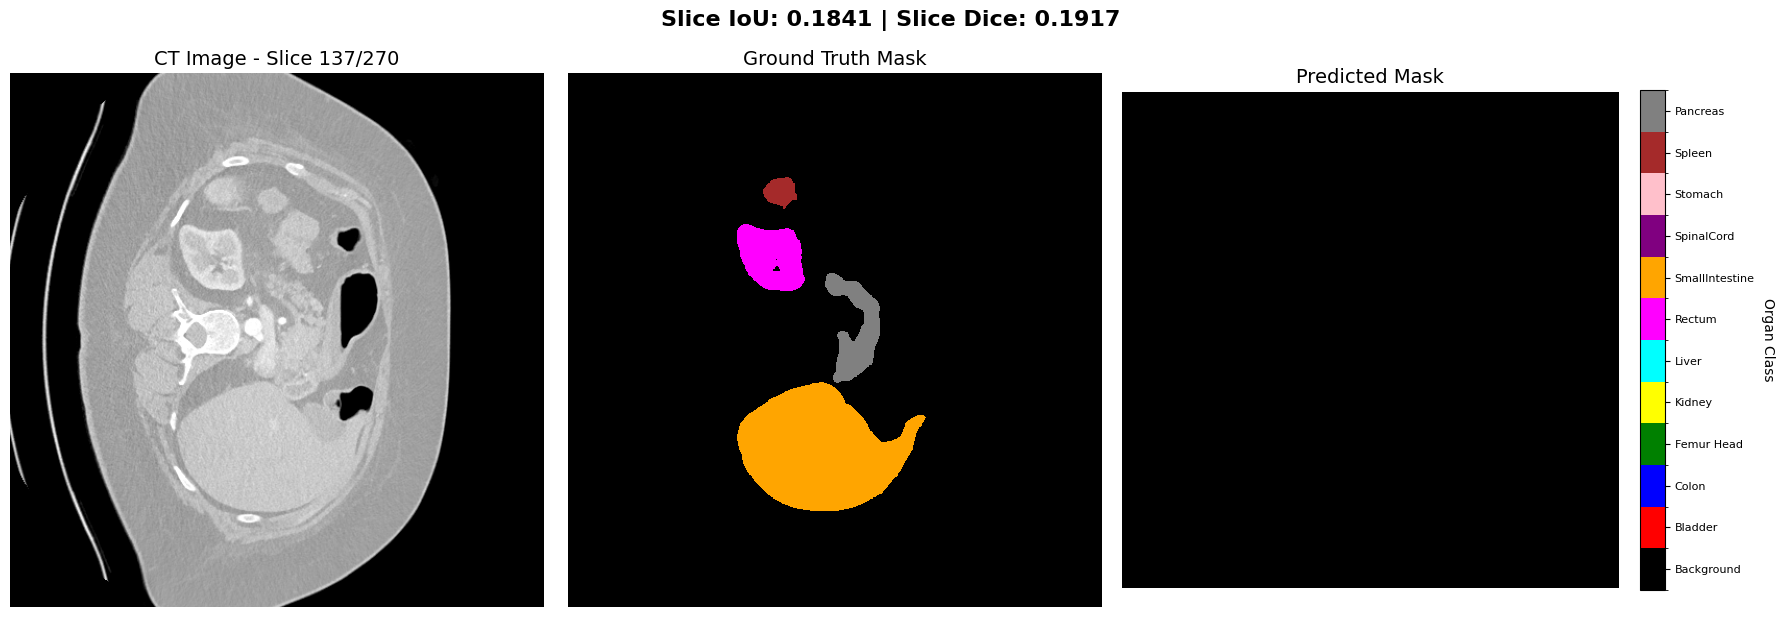

In [21]:
# Create interactive visualization with slider
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt

def visualize_slice(slice_idx, ct_data, gt_mask, pred_mask, cmap, norm):
    """
    Visualize a single slice with CT image, ground truth mask, and predicted mask
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot CT image
    axes[0].imshow(ct_data[:, :, slice_idx], cmap='gray', vmin=0, vmax=1)
    axes[0].set_title(f'CT Image - Slice {slice_idx + 1}/{ct_data.shape[2]}', fontsize=14)
    axes[0].axis('off')

    # Plot ground truth mask
    im1 = axes[1].imshow(gt_mask[:, :, slice_idx], cmap=cmap, norm=norm, interpolation='nearest')
    axes[1].set_title('Ground Truth Mask', fontsize=14)
    axes[1].axis('off')

    # Plot predicted mask
    im2 = axes[2].imshow(pred_mask[:, :, slice_idx], cmap=cmap, norm=norm, interpolation='nearest')
    axes[2].set_title('Predicted Mask', fontsize=14)
    axes[2].axis('off')

    # Add a single colorbar for the predicted mask, associated only with axes[2]
    cbar = fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Organ Class', rotation=270, labelpad=15)
    cbar.set_ticks(range(num_classes))
    cbar.set_ticklabels([organ_labels[i] for i in range(num_classes)], fontsize=8)

    # Calculate and display IoU and Dice score for this slice
    gt_slice = gt_mask[:, :, slice_idx].flatten()
    pred_slice = pred_mask[:, :, slice_idx].flatten()

    # Calculate per-class metrics
    unique_classes = np.unique(np.concatenate([gt_slice, pred_slice]))
    slice_iou = []
    slice_dice = []

    for cls in unique_classes:
        gt_cls = (gt_slice == cls)
        pred_cls = (pred_slice == cls)
        intersection = np.sum(gt_cls & pred_cls)
        union = np.sum(gt_cls | pred_cls)

        if union > 0:
            iou = intersection / union
            dice = (2 * intersection) / (np.sum(gt_cls) + np.sum(pred_cls))
        else:
            iou = 1.0  # Perfect match if both are empty
            dice = 1.0

        slice_iou.append(iou)
        slice_dice.append(dice)

    avg_iou = np.mean(slice_iou)
    avg_dice = np.mean(slice_dice)

    fig.suptitle(f'Slice IoU: {avg_iou:.4f} | Slice Dice: {avg_dice:.4f}',
                 fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

# Create interactive slider
interact(visualize_slice,
         slice_idx=IntSlider(min=0, max=num_slices-1, step=1, value=num_slices//2,
                            description='Slice Index', style={'description_width': 'initial'}),
         ct_data=fixed(ct_data_normalized),
         gt_mask=fixed(mask_data),
         pred_mask=fixed(predicted_masks),
         cmap=fixed(cmap),
         norm=fixed(norm))